# 大图挖掘1

copyright shiboshen19s@ict.ac.cn

##本笔记的主要内容如下：

1.   幂率分布知识
2.   以[wiki数据集](http://snap.stanford.edu/data/wiki-RfA.html )为基础，演示了课程中所讲的大图挖掘的一些模式和算法。
3.  简单介绍下欺诈检测（还是自己去查资料吧otz）




###1. 幂律分布
又叫zipf-like分布。因为一开始语言学家zipf研究英语字母使用频率时发现，如果给26个英文字母按照使用频率的高低排序，则它的使用频率和它的位次成反比。通俗的讲幂率分布就是小的东西用的多，大的东西用得少。

幂率分布是物理世界信息的一种分布，可表示成网络图的信息等都蕴含着幂率分布。幂率分布的属性可以用来生成仿真数据或者比较网络结构间的优劣。

$y=Cx^{-\alpha},x\gt0, \alpha>1$

幂率分布具有标度不变性（scale invariance），即x的伸缩变化引起y的线性伸缩变化：$y=C(\beta x)^{-\alpha}=\beta^{-\alpha}y$

画双对数曲线，则是完全的线性分布：$logy = -\alpha logx+logC \Rightarrow Y=-\alpha X+C'$,可以回归计算$\alpha$。

因此真实世界的网络模型也叫scale-free network，只有少数节点充当hub的作用（高degree，大中心度）,这些Hub的存在给了分布一个右长尾。网络的许多模式也符合幂率分布，比如度、邻接阵的特征值等。

幂率分布又叫偏态分布skewed-distribution，指比正态分布的对称图像向左或者向右多一个长尾出来。幂率分布的长尾在右侧（坐标轴正方向），故是右偏态分布。注：在右偏态分布中，中位数>平均数（因为长尾把位次拉长了，但是分布重头还是小数值那侧）；左偏态分布反之。

long-tail theory也启发了一种商业模式。

###2. 图的度符合幂律分布

In [0]:
#colab专用，加载自己的云端硬盘
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/BigDataAnalysis")

Mounted at /content/drive/


In [0]:
#预处理原始数据集（wiki-RfA.txt）形成稀疏邻接矩阵存储下来

import networkx as nx
import numpy as np
from scipy import linalg, sparse
import matplotlib.pyplot as plt
%matplotlib inline

def preprocess_txt(file):
    '''
    read a txt file and return a graph 
    '''
    name = dict() #{Alice:0, Bob:1}
    nameId = 0

    #Create edgelist
    with open(file, 'r') as f:
        graph = []
        for line in f:
            if line !='\n':
                l,r = line.split(':',1)
                if l=='SRC': 
                    if r not in name: 
                        name[r]=nameId
                        nameId += 1
                    src = name[r]
                elif l=='TGT':
                    if r not in name: 
                        name[r]=nameId
                        nameId += 1
                    tgt=name[r]
                elif l=='VOT':data=int(r.strip('\n'))
            else:
                pair = (src,tgt,data)
                graph.append(pair)
                continue             
    
    #form a graph 
    G = nx.Graph()
    G.add_weighted_edges_from(graph)
    Wiki = nx.to_scipy_sparse_matrix(G)
    sparse.save_npz('coursedata/wiki.npz',Wiki)
    
preprocess_txt('coursedata/wiki-RfA.txt')

In [0]:
#加载稀疏邻接矩阵，给之后的实验备用
mat = sparse.load_npz('coursedata/wiki.npz')

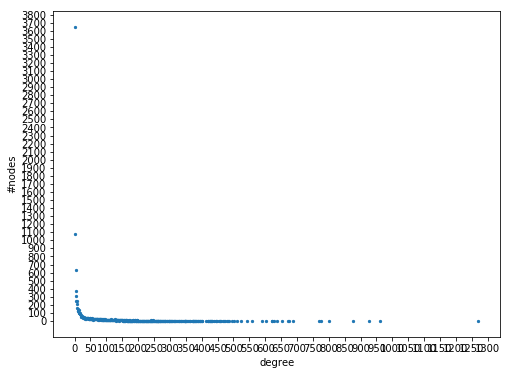

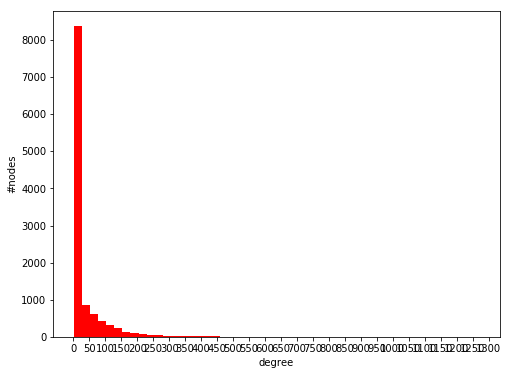

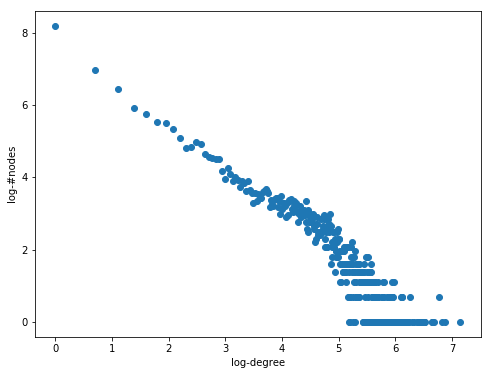

In [0]:
#画图的度分布散点图和直方图，观察幂率分布(还可以拟合alpha玩玩但是这里就不做了)


G = nx.to_networkx_graph(mat)
degree_dict = dict()
x = list()
for e in G.degree:
    if e[1] not in degree_dict:
        degree_dict[e[1]] = 1
    else:
        degree_dict[e[1]] += 1
    x.append(e[1])

d = list()
dnum = list()
for key, value in degree_dict.items():
    d.append(key)
    dnum.append(value)
plt.figure(num=2,figsize=(8, 6)) #add this line to avoid drawing different pictures in the same canvas
xt = np.arange(0,1500,50)
yt = np.arange(0,4000,100)
plt.xticks(xt)
plt.yticks(yt)
plt.xlabel('degree')
plt.ylabel('#nodes')
fig = plt.scatter(d,d_num,s=5) #
plt.figure(figsize=(8, 6))
plt.xlabel('degree')
plt.ylabel('#nodes')
plt.xticks(xt)
fig = plt.hist(x,bins=50, color='red')
plt.figure(figsize=(8, 6))
d_log = np.log(np.array(d))
dnum_log = np.log(np.array(dnum))
plt.xlabel('log-degree')
plt.ylabel('log-#nodes')
plt.scatter(d_log,dnum_log)
plt.show()

###3. 图邻接阵的奇异值、拉普拉斯阵的特征值

一些统计规律：
1.   从度的幂率分布可以推出图邻接阵的奇异值，拉普拉斯阵的特征值分布都符合幂率分布，反之不能。
2.   邻接阵的奇异值的幂率分布最显著（$\alpha比较大$）。所以任意拿来一个大图，我们有把握假设奇异值符合幂率分布。
3.   通常**度分布**和**拉普拉斯阵的特征值分布**有高度一致性，首先它们很多时候会同时是幂率分布(one implies the other)，而且拿一个的$\alpha$和cutoff去拟合另一个分布结果通常都很好。
4. 应用：实际计算时可以用top的几个值代表整个矩阵，不用全都算出来。scipy的默认函数（svd分解、特征分解等）是计算6个值。这被称作scale-law。

截断值cut-off value : $x_{min}$，计算$x>x_{min}$时的分布图

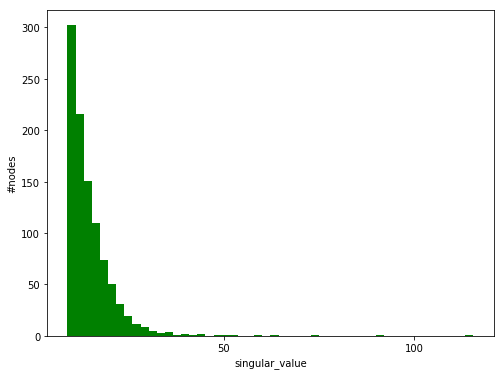

In [0]:

mat = mat.asfptype()
k = min(mat.shape[0],mat.shape[1]) #upper bound of svd's param k, but takes too much time
U, s,Vh = sparse.linalg.svds(mat,k=1000) ##only compute 1k eigen values is enough to reveal fact
plt.figure(figsize=(8, 6))
plt.xlabel('singular_value')
plt.ylabel('#nodes')
xt = np.arange(0,1500,50)
plt.xticks(xt)
fig = plt.hist(s,bins=50, color='green')
plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


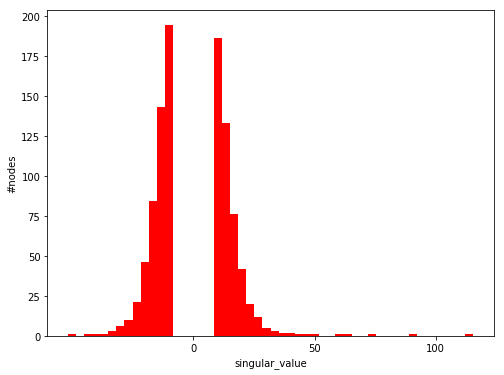

In [0]:
from scipy.sparse.linalg import eigs
mat = mat.asfptype()
vals, vecs = eigs(mat,k=1000)  #only compute 1k eigen values is enough to reveal fact
plt.figure(figsize=(8, 6))
plt.xlabel('singular_value')
plt.ylabel('#nodes')
xt = np.arange(0,1500,50)
plt.xticks(xt)
fig = plt.hist(vals,bins=50, color='red')
plt.show()

###4. 图中的三角形

三角形计数是图的重要模式之一。一般情况下社交网络图的三角形数目比期望高许多（朋友的朋友很可能是朋友，这种节点属性传递性）。通过检测异常高的三角形数目可以进行图异常检测、僵尸发现等算法。
####4.1 n nodes m edges graph的一般算法
$P(三角形存在)=P(从节点中任选三个点)*P(每两个点存在连边) =P(从节点中任选三个点)*P(从边集合拿出一条分配给其中两个节点)^{3}=C_{n}^{3}*(\frac{m}{C_{n}^{2}})^{3}=\frac{3}{4}*(\frac{m}{n})^{3}$

这给出了三角形存在的期望值。当节点数加倍时（比如，朋友数double），三角形数目实际上翻了三倍。

为计数三角形（实现过程略）：

1.   三角形即节点序列(v1,v2,v3)， 其中次序从小到大防止重复计数。
2.   给节点集建立唯一次序关系：首先每个节点有0或1起始的数字编号。然后按照degree大小排序，相同degree按照数字编号顺序排列。扫描adj矩阵的n行即可得到度序列，O(n)。
3. 首先寻找hub三角形：hub节点是degree>$\sqrt{m}$的节点并且数目不超过2$\sqrt{m}$。（边数最大为m，故解不等式$\sqrt{m}*x*1/2\leq m$）。hub三角形是由三个Hub节点构成的，寻找这样的三角形复杂度为O($m^{3/2}$)。暴力解法：先把所有的Hub节点搜出来，然后三重循环判断，每重都是O($\sqrt{m}$)。
4. 寻找一般三角形：考虑每条边(v1,v2)，如果v1和v2都为hub节点则忽略这条边；但如果假定v1不是hub节点并且有v1<v2，令u1,u2,...,uk为与v1相邻的节点，其中k<$\sqrt{m}$，利用节点索引在O(1)时间内找到这些节点；对于每个节点ui，利用边索引在O(1)时间内判断边(ui,v2)是否存在；当且仅当边(ui,v2)存在，并且v1<ui时，对三角形(v1,v2,ui)计数，时间为Time(考虑每条边)$*$Time(考虑v1的所有邻居)=O(m)*O($\sqrt{m}$)=O($m^{3/2}$)。
5. 所以一般计数的复杂度是边的3/2次方。对于动辄上百万千万边的大图来说是不可接受的。
6.  可以用MapReduce实现以上的算法。

####4.2 fast couting  [ppt上的论文的一些解读]

引理1：图中长度$l$的$vi->vj$闭环行走的路线数是$A^{l}_{ij}$

引理2：$tr(A)=\sum{\lambda_{i}}$

定理1：图中随机三角形的数目约为$\frac{tr(A^{3})}{6}$。

证明：把三角形(vi vj vk)看成长度为3的，任一个点出发在图中游走后又回到自己的闭环行走所经过的点序列集合的子集。根据引理所有长是3的闭环行走路线数目是tr($A^{3}$), 而一个三角形中有3!=6种顶点排列顺序。

推论1：图中随机三角形的数目为$\frac{\sum{\lambda_{i}^{3}}}{6},\lambda_{i}是top-ith eigenvalue (absolute value)$

推论2： 图中包含$node_{i}$的随机三角形的数目$\frac{\sum_{j}{\lambda_{j}^{3}u_{i,j}}}{2}$


---


快速算法1： GlobalEigenTriangle:


1.   通过lanczos方法不断计算当前最重要的特征值然后加入集合，直到当前计算第 $i$个特征值时$\frac{|\lambda_{i}|^{3}}{\sum_{j}{|\lambda_{j}|^{3}}}\leq threshould$，把它加入已经计算好的特征值集合然后停机。
2.   用已经计算出的特征值根据推论1估算三角形数目



---

快速算法2： LocalEigenTriangle:


1.   通过lanczos方法不断计算当前最重要的特征值和特征向量然后分别加入集合1，2，直到当前计算第 $i$个特征值时$\frac{|\lambda_{i}|^{3}}{\sum_{j}{|\lambda_{j}|^{3}}}\leq threshould$，把它的特征值和特征向量加入已经计算好的集合1，2然后停机。
2.   对j loop from 1 to n: 通过集合1，2 的知识和推论2计算包含节点j的三角形数目。

####4.3 triangle的一些pattern


1.   参与三角形的节点数目符合幂率分布：坐标对是（节点id,参与的三角形数目），画三角形数目-参与三角形的节点数目曲线。
2.   度和三角形数目的幂率分布：对于每个degree di，计算degree=di的所有节点参与的三角形数目的平均值ti, di-ti符合幂率分布。





